# Practica 4a

In [19]:
from sklearn.datasets import load_diabetes
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso


In [20]:
# Cargamos el dataset
x = load_diabetes()
df = pd.DataFrame(x.data, columns = x.feature_names)
df["MEDV"] = x.target
X = df.drop("MEDV",1)   #Características
y = df["MEDV"]          #Target
df.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,MEDV
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641,135.0


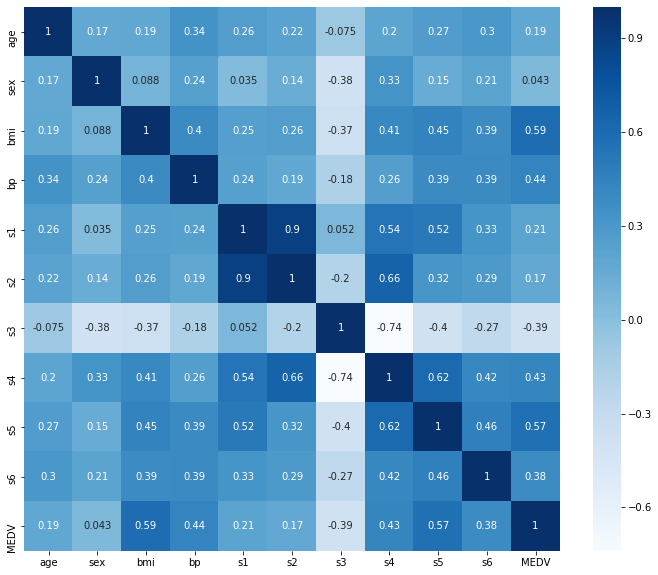

In [21]:
plt.figure(figsize=(12,10))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Blues)
plt.show()

In [22]:
#Correlación respecto a la variable de salida o target
cor_target = abs(cor["MEDV"])

#Selección de características altamente correlacionadas
relevant_features = cor_target[cor_target>0.5]
relevant_features

bmi     0.586450
s5      0.565883
MEDV    1.000000
Name: MEDV, dtype: float64

In [23]:
print(df[["bmi","s5"]].corr())

          bmi        s5
bmi  1.000000  0.446159
s5   0.446159  1.000000


In [25]:
X_1 = sm.add_constant(X)
model = sm.OLS(y,X_1).fit()
model.pvalues.sort_values(ascending=False)

age       8.669998e-01
s3        6.347207e-01
s6        3.059983e-01
s4        2.734557e-01
s2        1.603892e-01
s1        5.794735e-02
sex       1.041429e-04
s5        1.556021e-05
bp        1.023819e-06
bmi       4.299558e-14
const    1.009679e-208
dtype: float64

In [27]:
#Eliminamos las variables mayores a 0.5, creo xD
cols = list(X.columns)
pmax = 1

while (len(cols)>0):
    p = []
    X_1 = X[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax > 0.05):
        cols.remove(feature_with_p_max)
    else:
        break
        
selected_features_BE = cols
print(selected_features_BE)

['sex', 'bmi', 'bp', 's1', 's2', 's5']


In [31]:
model = LinearRegression()

#Método RFE
rfe = RFE(model, 3, verbose=1)

#Transformando los datos usando el método RFE
X_rfe = rfe.fit_transform(X,y)  

#Encontrando el modelo de los datos
model.fit(X_rfe,y)
print(rfe.support_)
print(rfe.ranking_)

Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
[False False  True False  True False False False  True False]
[8 4 1 3 1 2 6 5 1 7]


In [32]:

#Número de características
nof_list = np.arange(1,10)            
high_score = 0

#Proceso para almacenar las características óptimas
nof = 0           
score_list = []

for n in range(len(nof_list)):
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 0)
    model = LinearRegression()
    rfe = RFE(model,nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe,y_train)
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
        
print("Número óptimo de características: %d" %nof)

Número óptimo de características: 7


In [34]:
cols = list(X.columns)
model = LinearRegression()
#Initializing RFE model
rfe = RFE(model, 7)             
#Transforming data using RFE
X_rfe = rfe.fit_transform(X,y)  
#Fitting the data to model
model.fit(X_rfe,y)              
temp = pd.Series(rfe.support_,index=cols)
selected_features_rfe = temp[temp==True].index
print(selected_features_rfe)

Index(['sex', 'bmi', 'bp', 's1', 's2', 's4', 's5'], dtype='object')


In [35]:
reg = LassoCV()
reg.fit(X, y)
coef = pd.Series(reg.coef_, index = X.columns)
print("Número óptimo de características:" + str(sum(coef != 0)))
print("Desempeño mediante la regularización Lasso: %f" %reg.score(X,y))

C:\Users\Alumno\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Número óptimo de características:9
Desempeño mediante la regularización Lasso: 0.515380


Text(0.5, 1.0, 'Importancia de las características usando el modelo de Lasso')

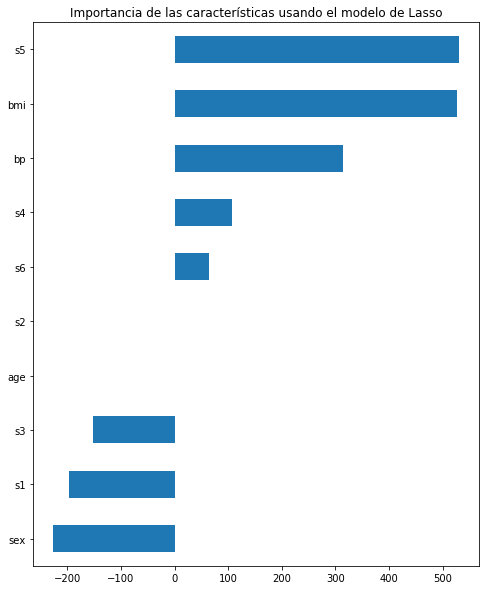

In [36]:
imp_coef = coef.sort_values()
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Importancia de las características usando el modelo de Lasso")